In [476]:
import pandas as pd
from pymongo import MongoClient
import plotly
# plotly.offline.init_notebook_mode(connected=True)
plotly.io.renderers.default= 'png'
import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta

def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """

    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)


    return conn[db]

db = _connect_mongo(host='localhost', port=27017, username=None, password=None, db='OpenRoadDB')

KPI = db.kpi
ENGINE = db.engine_history

# run_id_meta = {

#     'HlVRquRtQTtm': 'Random',
#     'KwovO2tSWqoy': 'Greedy Pickup',
#     'WIISylDCJjsl': 'Greedy Revenue',
#     'W6mtB7vi7MlO': 'Greedy Service',
#     'pPoiOM6H0sKJ': 'Compromise',
# } # 20211117_D200_P2000_4Hx30s

run_id_meta = {
    'mBRubqbABrfB': 'Greedy Pickup',
    'h7ca3Vl77s81': 'Greedy Pickup 2',
} # 20211117_D200_P4000_8Hx60s

# plotly.io.renderers


In [477]:
# cursor = db.engine_history.find({
#             'run_id': 'xSx0cwH3JgTH',
#         },
#         projection={ '_id': 0, 'online_params.realtime_reverse_pickup_time_step': 1},
#         sort=[('online_params.realtime_reverse_pickup_time_step', -1)]
#     )

# list(cursor)

In [478]:
def get_pivot(collection, run_id_meta, metric):
    cursor = collection.find({
            'run_id': {'$in': [k for k, _ in run_id_meta.items()]},
            'metric': metric
        },
        projection={ '_id': 0, 'run_id': 1, 'sim_clock': 1, 'value': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))

    metric_pivot = pd.pivot_table(metric_df, 
                                  index='sim_clock', 
                                  columns='run_id', 
                                  values='value').rename(columns=run_id_meta)
    cumulative_pivot = metric_pivot.cumsum()

    return metric_pivot, cumulative_pivot




In [479]:
sum_metric = [
    'served', 
    'cancelled',
    'revenue', 
    'wait_time_pickup',
    'service_score'
]
avg_metric_byServed = [
    'revenue', 
    'wait_time_pickup',
    # 'wait_time_driver_confirm', 
    # 'wait_time_assignment',
    'service_score'
]



gamma = 1.2
# Sum(Revenue) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_revenue Scenario
target_revenue = 16576 * gamma / 480
print(f"{target_revenue=}")

# Sum(pickup_budget) - Sum(pickup_time) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_pickup Scenario
# Budget Computed by max Pickup (600) * Num_Served 
target_pickup_time = ((600*1423) - (689910)) * gamma / 480 / 10
# target_pickup_time = ((600*1423) ) * gamma / 480 / 100
print(f"{target_pickup_time=}")

# Sum(service_score) / num_steps / Scale_factor
# Scale_factor as needed for normalization
# Data from Greedy_service Scenario
target_service = 131549 * gamma / 480 / 10
print(f"{target_service=}")



target_revenue=41.440000000000005
target_pickup_time=40.972500000000004
target_service=32.88725


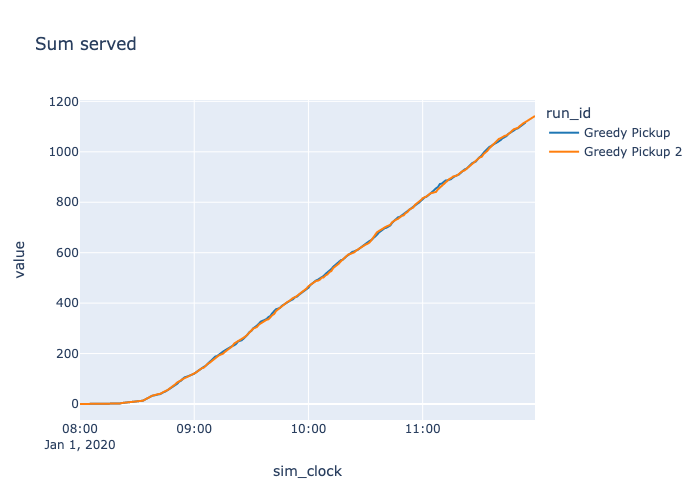

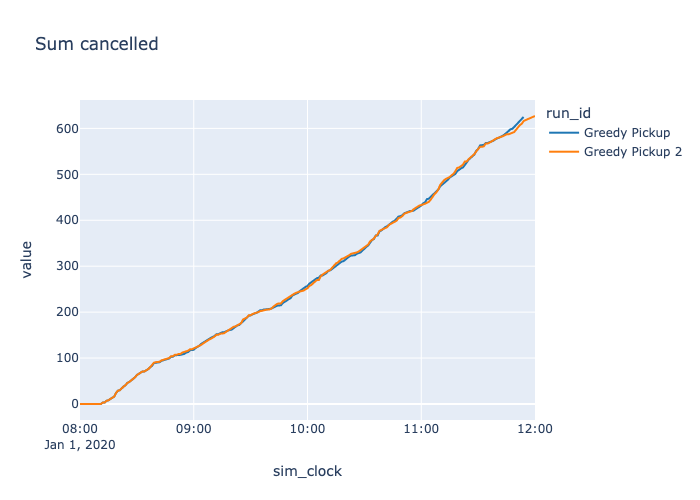

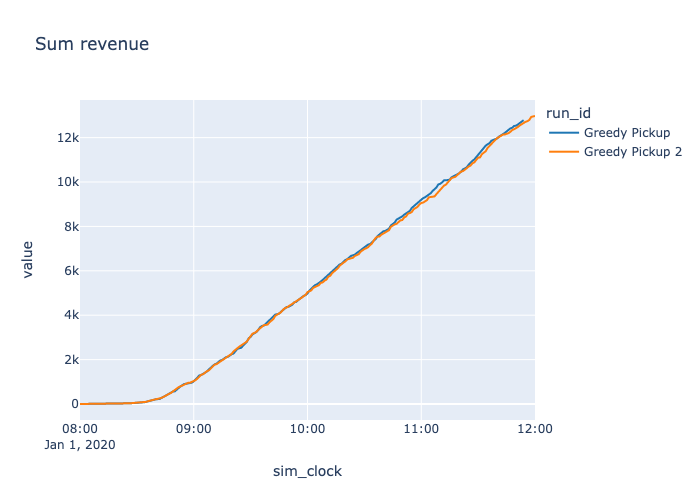

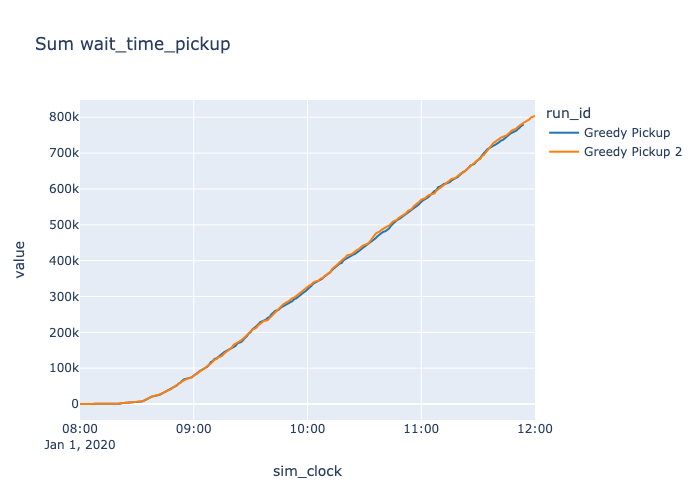

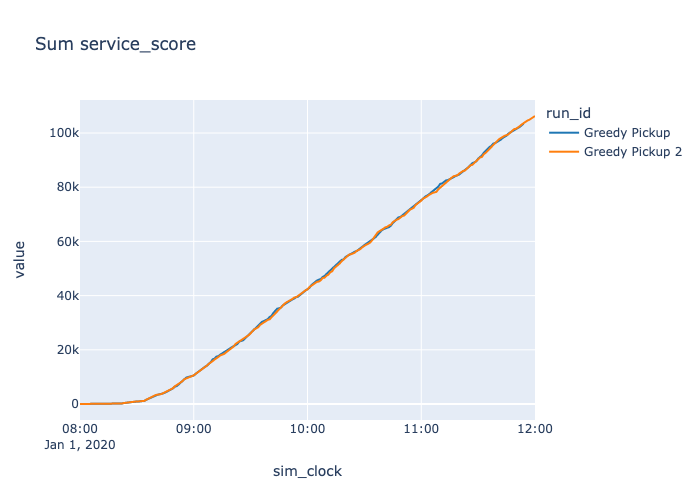

In [482]:
from IPython.display import Image

for m in sum_metric:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    # print(cum_pivot.tail(1))

    fig = px.line(cum_pivot, title=f"Sum {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
    fig.show()


    

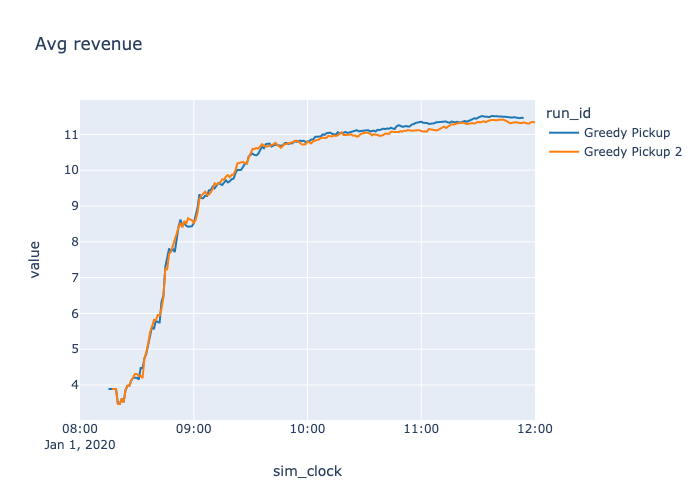

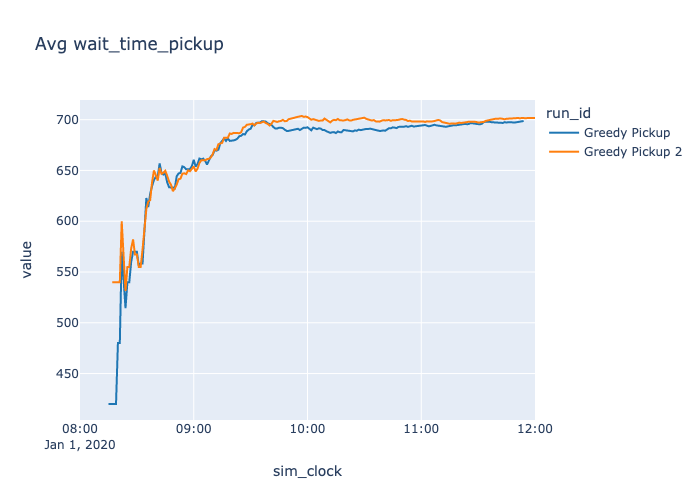

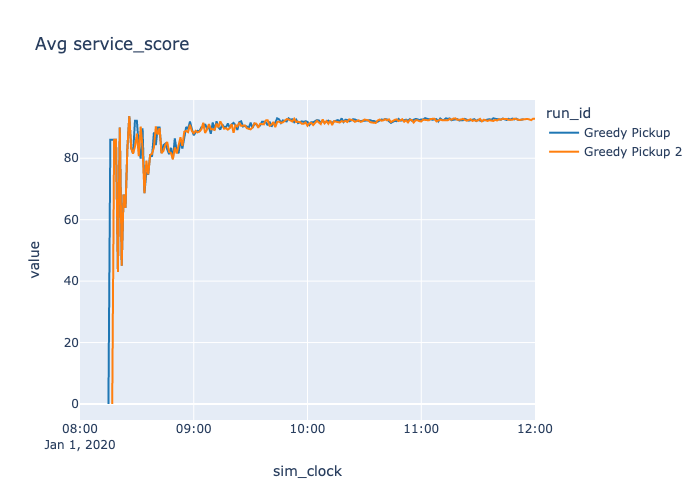

In [483]:

served_pivot, cum_served_pivot = get_pivot(KPI, run_id_meta, 'served')
for m in avg_metric_byServed:
    metric_pivot, cum_pivot = get_pivot(KPI, run_id_meta, m)
    metric_pivot = metric_pivot / served_pivot
    cum_pivot = cum_pivot / cum_served_pivot

    fig = px.line(cum_pivot, title=f"Avg {m}",
                 color_discrete_sequence=px.colors.qualitative.D3,
                 category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
    fig.show()

    

In [454]:
# # num_accepted_pivot = get_cumulative_pivot(KPI, run_id_meta, 'num_accepted')
# for m in avg_metric_byAccepted:
#     metric_pivot = get_cumulative_pivot(KPI, run_id_meta, m) / num_accepted_pivot

#     fig = px.line(metric_pivot, title=f"Avg {m}",
#                  color_discrete_sequence=px.colors.qualitative.D3,
#                  category_orders={'run_id': [v for _, v in run_id_meta.items()]}) 
#     fig.show()


# # num_accepted_pivot.head(50)



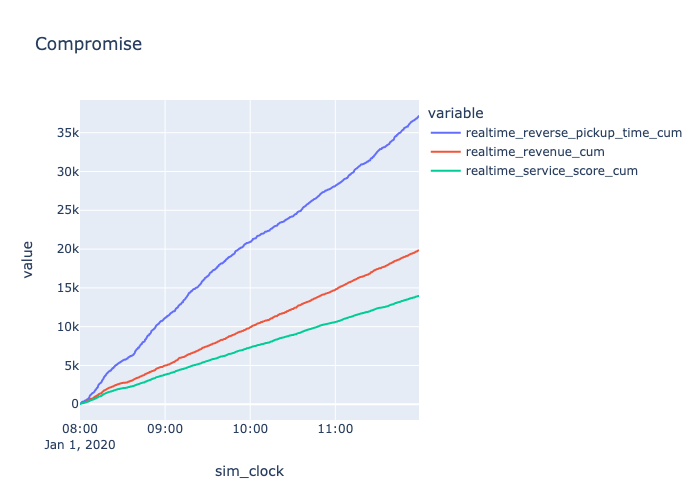

In [455]:

def get_engine_perf(collection, run_id_list):
    cursor = collection.find({
            'run_id': {'$in': run_id_list},
        },
        projection={ '_id': 0, 'online_params': 1, 'sim_clock': 1, 'runtime_performance': 1,},
        sort=[('sim_clock', 1)]
    )

    metric_df = pd.DataFrame(list(cursor))
    metric_df = pd.concat([metric_df.drop(['online_params'], axis=1), metric_df['online_params'].apply(pd.Series)], axis=1)
    metric_df = pd.concat([metric_df.drop(['runtime_performance'], axis=1), metric_df['runtime_performance'].apply(pd.Series)], axis=1)

    metric_df

    return metric_df



engine_df = get_engine_perf(ENGINE, [k for k, v in run_id_meta.items() if v == 'Compromise'])


fig = px.line(engine_df, x='sim_clock', 
              y=['realtime_reverse_pickup_time_cum','realtime_revenue_cum', 'realtime_service_score_cum',
                # 'exp_target_reverse_pickup_time','exp_target_revenue', 'exp_target_service_score'
                ],
              title='Compromise') #, labels = run_id_meta)
fig.show()


In [456]:
# plotly.io.renderers.default= 'jupyterlab'

# engine_df['sim_clock'] = engine_df.sim_clock.apply(lambda x: x).apply(str)

# fig = px.bar(engine_df, 
#               y=['realtime_reverse_pickup_time_cum','realtime_revenue_cum', 'realtime_service_score_cum',],
#              barmode='group',
             
#              animation_frame='sim_clock',
#               title='Compromise') #, labels = run_id_meta)
# fig.show()



In [439]:
# engine_df.tail(100)